# ECG Masking Strategy Visualization (Patch-Level)

This notebook visualizes the two masking strategies **at the patch level**:
- Each ECG is divided into **200 patches** (25 samples each, all 12 leads)
- Masking happens on patches, not raw samples
- We show the patch boundaries to understand the granularity

**Strategies:**
1. **Original ECG-JEPA (Mask-and-Complement)**: Masks 75-85% of patches.
2. **I-JEPA (Context-to-Target)**: ONE contiguous context block (85-95%), 4 target blocks (15-20% each).

**IMPORTANT:** Restart kernel if you modified `data/masks.py`!

In [8]:
import sys
import os
from pathlib import Path
import importlib

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

sys.path.insert(0, os.getcwd())

import data.masks
importlib.reload(data.masks)
from data.masks import MaskCollator, IJEPAMaskCollator

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.grid'] = False

print("Masks module reloaded!")

Masks module reloaded!


In [9]:
DATA_PATH = Path("../../ecg/data/ptb-xl.npy")
NUM_EXAMPLES = 3
PATCH_SIZE = 25
NUM_PATCHES = 200
CROP_SIZE = PATCH_SIZE * NUM_PATCHES
CHANNELS = 12
SAMPLING_FREQUENCY = 500
LEAD_TO_PLOT = 1

def load_real_batch(path: Path, num_examples: int):
    if path.is_file():
        arr = np.load(path, mmap_mode='r')
        sample_ids = np.random.choice(len(arr), size=num_examples, replace=False)
        batch = []
        for idx in sample_ids:
            sample = np.array(arr[idx])
            ecg = sample if sample.shape[0] == CHANNELS else sample.T
            if ecg.shape[1] < CROP_SIZE:
                pad = np.zeros((CHANNELS, CROP_SIZE), dtype=ecg.dtype)
                pad[:, :ecg.shape[1]] = ecg
                ecg = pad
            elif ecg.shape[1] > CROP_SIZE:
                start = np.random.randint(0, ecg.shape[1] - CROP_SIZE + 1)
                ecg = ecg[:, start:start + CROP_SIZE]
            batch.append(torch.from_numpy(ecg).float())
        print(f"Loaded {len(batch)} ECGs from {path}")
        return batch
    else:
        print(f"File not found. Using synthetic signals.")
        return [torch.randn(CHANNELS, CROP_SIZE) for _ in range(num_examples)]

ecgs = load_real_batch(DATA_PATH, NUM_EXAMPLES)

Loaded 3 ECGs from ../../ecg/data/ptb-xl.npy


In [10]:
original_collator = MaskCollator(
    patch_size=PATCH_SIZE, 
    min_block_size=10, 
    min_keep_ratio=0.15, 
    max_keep_ratio=0.25
)

ijepa_collator = IJEPAMaskCollator(
    patch_size=PATCH_SIZE,
    context_scale=(0.85, 0.95),
    pred_scale=(0.15, 0.20),
    num_pred_blocks=4,
    min_keep=10
)

_, orig_context, orig_targets = original_collator(ecgs)
_, ijepa_context_list, ijepa_targets_list = ijepa_collator(ecgs)

print("Original ECG-JEPA:")
print(f"  Context: {orig_context.shape} -> {orig_context.shape[1]} patches per sample")
print(f"  Targets: {orig_targets.shape} -> {orig_targets.shape[1]} patches per sample")

print("\nI-JEPA:")
print(f"  Context: {ijepa_context_list[0].shape}")
for i, t in enumerate(ijepa_targets_list):
    print(f"  Target {i+1}: {t.shape}")

Original ECG-JEPA:
  Context: torch.Size([3, 40]) -> 40 patches per sample
  Targets: torch.Size([3, 160]) -> 160 patches per sample

I-JEPA:
  Context: torch.Size([3, 92])
  Target 1: torch.Size([3, 31])
  Target 2: torch.Size([3, 39])
  Target 3: torch.Size([3, 36])
  Target 4: torch.Size([3, 35])


In [11]:
def plot_patch_level(ecg, context_patches, target_patches_list, sample_idx, title, lead=LEAD_TO_PLOT):
    """
    Plot masking at the PATCH level, showing patch boundaries.
    
    Args:
        ecg: [C, T] tensor
        context_patches: set or list of context patch indices
        target_patches_list: list of lists, each inner list is one target block's patches
        sample_idx: sample number for title
        title: plot title
    """
    lead_signal = ecg[lead].numpy()
    time_axis = np.arange(len(lead_signal)) / SAMPLING_FREQUENCY
    seconds_per_patch = PATCH_SIZE / SAMPLING_FREQUENCY
    total_duration = len(lead_signal) / SAMPLING_FREQUENCY
    
    # Convert to sets for easy lookup
    context_set = set(context_patches)
    all_target_set = set()
    for block in target_patches_list:
        all_target_set.update(block)
    
    # Calculate stats
    ctx_pct = len(context_set) / NUM_PATCHES * 100
    tgt_pct = len(all_target_set) / NUM_PATCHES * 100
    ignored = NUM_PATCHES - len(context_set) - len(all_target_set - context_set)
    
    print(f"--- {title} ---")
    print(f"Context: {len(context_set)} patches ({ctx_pct:.1f}%)")
    print(f"Targets: {len(all_target_set)} patches ({tgt_pct:.1f}%)")
    print(f"Ignored (neither): {ignored} patches ({ignored/NUM_PATCHES*100:.1f}%)")
    
    for i, block in enumerate(target_patches_list):
        block_unique = sorted(set(block))
        if len(block_unique) > 0:
            print(f"  T{i+1}: patches {block_unique[0]}-{block_unique[-1]} ({len(block_unique)} patches, {len(block_unique)/NUM_PATCHES*100:.1f}%)")
    print("-" * 50)
    
    # Colors
    color_context = '#3498DB'
    color_ignored = '#BDC3C7'
    target_colors = sns.color_palette("husl", len(target_patches_list))
    
    fig, (ax_patches, ax_signal) = plt.subplots(2, 1, figsize=(16, 5), 
                                                  height_ratios=[1, 3],
                                                  sharex=True, dpi=120)
    
    # --- Top: Patch-level visualization ---
    for p in range(NUM_PATCHES):
        x0 = p * seconds_per_patch
        x1 = (p + 1) * seconds_per_patch
        
        # Determine patch color
        in_target = None
        for i, block in enumerate(target_patches_list):
            if p in block:
                in_target = i
                break
        
        if in_target is not None:
            color = target_colors[in_target]
            alpha = 0.7
        elif p in context_set:
            color = color_context
            alpha = 0.5
        else:
            color = color_ignored
            alpha = 0.3
        
        ax_patches.axvspan(x0, x1, color=color, alpha=alpha, lw=0)
        
        # Draw patch boundary
        ax_patches.axvline(x0, color='white', lw=0.3, alpha=0.5)
    
    ax_patches.set_xlim(0, total_duration)
    ax_patches.set_ylim(0, 1)
    ax_patches.set_ylabel('Patches', fontsize=10)
    ax_patches.set_yticks([])
    ax_patches.set_title(title, fontsize=14, fontweight='bold', loc='left')
    
    # Add patch number markers every 20 patches
    for p in range(0, NUM_PATCHES + 1, 20):
        x = p * seconds_per_patch
        ax_patches.axvline(x, color='black', lw=0.8, alpha=0.5)
        ax_patches.text(x, 1.1, str(p), ha='center', fontsize=8, transform=ax_patches.get_xaxis_transform())
    
    # --- Bottom: Signal with colored segments ---
    for p in range(NUM_PATCHES):
        start_sample = p * PATCH_SIZE
        end_sample = (p + 1) * PATCH_SIZE
        patch_time = time_axis[start_sample:end_sample]
        patch_signal = lead_signal[start_sample:end_sample]
        
        in_target = None
        for i, block in enumerate(target_patches_list):
            if p in block:
                in_target = i
                break
        
        if in_target is not None:
            color = target_colors[in_target]
            lw = 1.5
        elif p in context_set:
            color = color_context
            lw = 1.2
        else:
            color = color_ignored
            lw = 0.8
        
        ax_signal.plot(patch_time, patch_signal, color=color, linewidth=lw)
    
    ax_signal.set_xlim(0, total_duration)
    ax_signal.set_xlabel("Time (s)", fontsize=10)
    ax_signal.set_ylabel("Amplitude (mV)", fontsize=10)
    sns.despine(ax=ax_signal, offset=5)
    sns.despine(ax=ax_patches, left=True, bottom=True)
    
    # Legend
    from matplotlib.lines import Line2D
    legend_elements = [
        mpatches.Patch(facecolor=color_context, alpha=0.5, label='Context'),
        mpatches.Patch(facecolor=color_ignored, alpha=0.3, label='Ignored'),
    ]
    for i in range(len(target_patches_list)):
        legend_elements.append(mpatches.Patch(facecolor=target_colors[i], alpha=0.7, label=f'Target {i+1}'))
    
    ax_signal.legend(handles=legend_elements, loc='upper right', frameon=True, framealpha=0.9, ncol=3)
    
    plt.tight_layout()
    plt.show()

## Strategy 1 – Original ECG-JEPA

Masks 75-85% of patches (targets), keeps 15-25% as context.
Context and targets are complementary (no ignored patches).

--- ECG-JEPA Sample 1 ---
Context: 40 patches (20.0%)
Targets: 160 patches (80.0%)
Ignored (neither): 0 patches (0.0%)
  T1: patches 26-199 (160 patches, 80.0%)
--------------------------------------------------


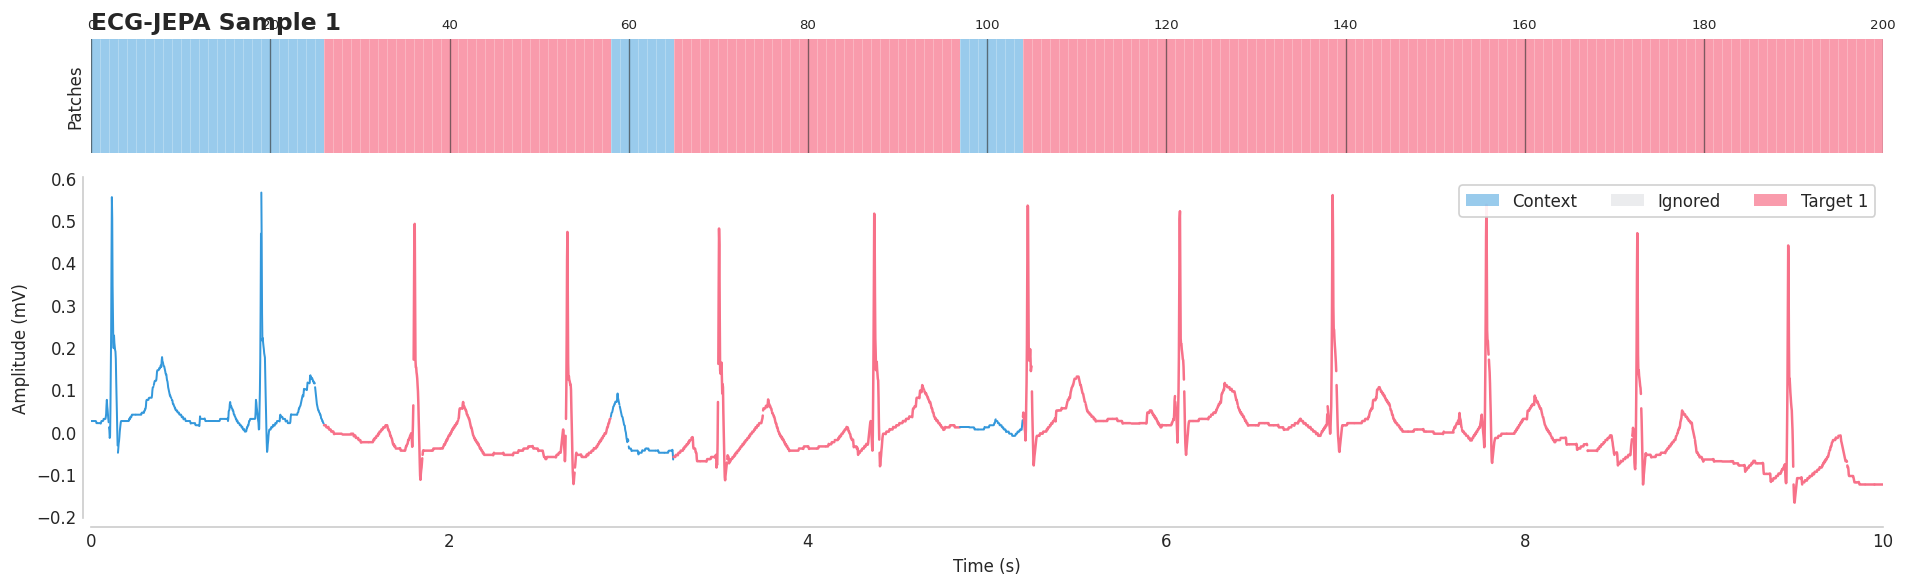

--- ECG-JEPA Sample 2 ---
Context: 40 patches (20.0%)
Targets: 160 patches (80.0%)
Ignored (neither): 0 patches (0.0%)
  T1: patches 9-183 (160 patches, 80.0%)
--------------------------------------------------


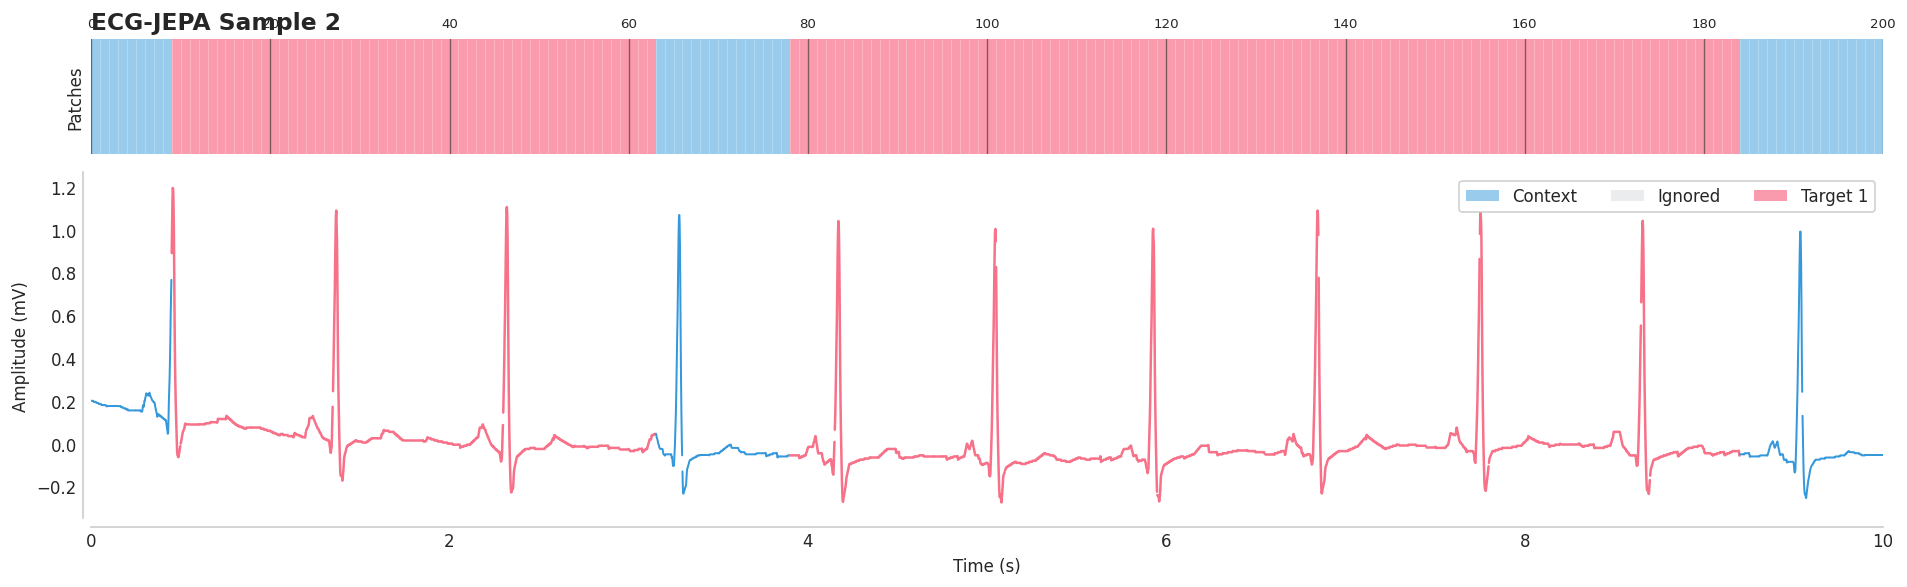

--- ECG-JEPA Sample 3 ---
Context: 40 patches (20.0%)
Targets: 160 patches (80.0%)
Ignored (neither): 0 patches (0.0%)
  T1: patches 0-168 (160 patches, 80.0%)
--------------------------------------------------


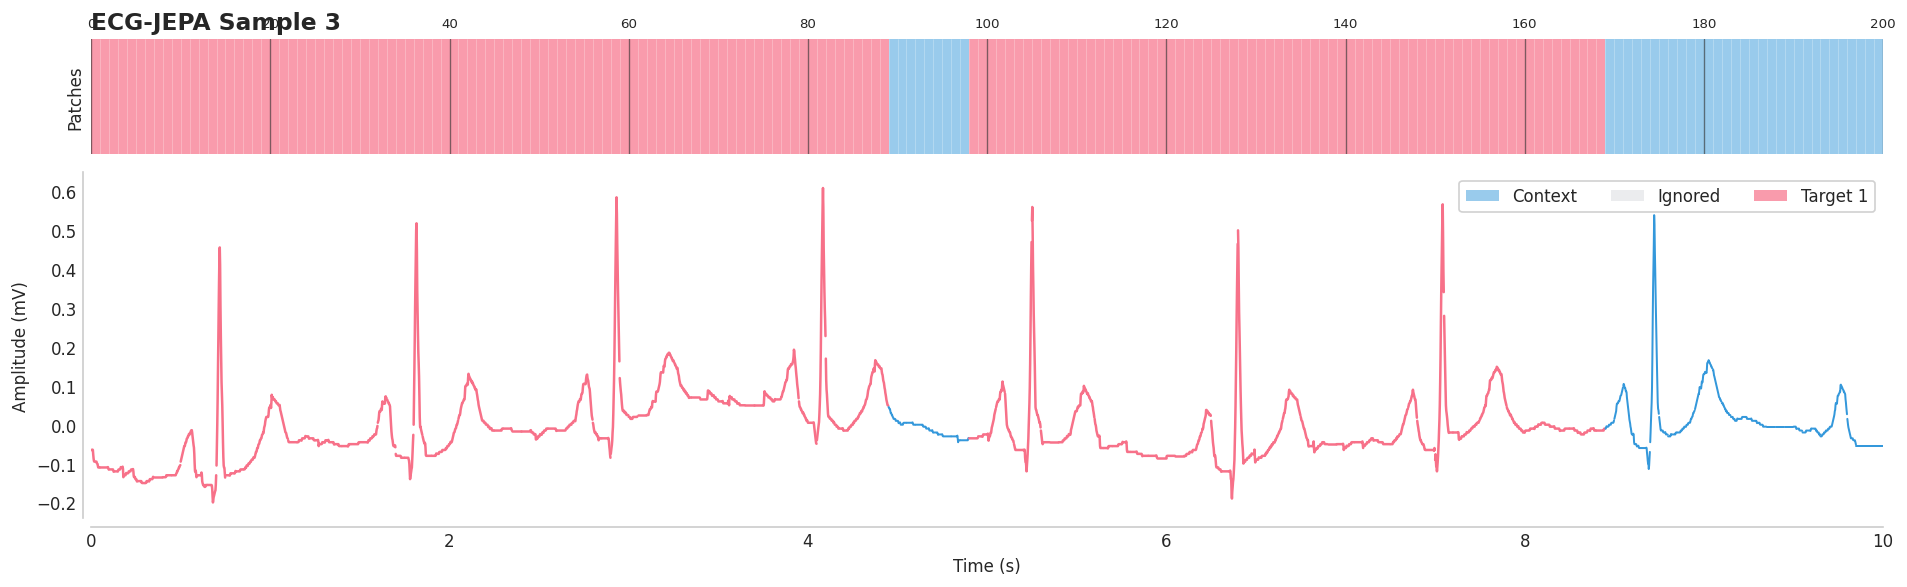

In [12]:
for i in range(NUM_EXAMPLES):
    ctx = orig_context[i].numpy().tolist()
    tgt = orig_targets[i].numpy().tolist()
    # Original strategy: one big target block (all masked patches)
    plot_patch_level(ecgs[i], ctx, [tgt], i, f"ECG-JEPA Sample {i+1}")

## Strategy 2 – I-JEPA

1. Samples ONE large contiguous context block (85-95% of signal)
2. Samples 4 target blocks (each 15-20%)
3. Removes overlap between context and targets

**Note:** The initial context may not start at patch 0, leaving some patches "ignored" at the edges.

--- I-JEPA Sample 1 ---
Context: 92 patches (46.0%)
Targets: 86 patches (43.0%)
Ignored (neither): 22 patches (11.0%)
  T1: patches 38-68 (31 patches, 15.5%)
  T2: patches 19-57 (39 patches, 19.5%)
  T3: patches 144-179 (36 patches, 18.0%)
  T4: patches 28-62 (35 patches, 17.5%)
--------------------------------------------------


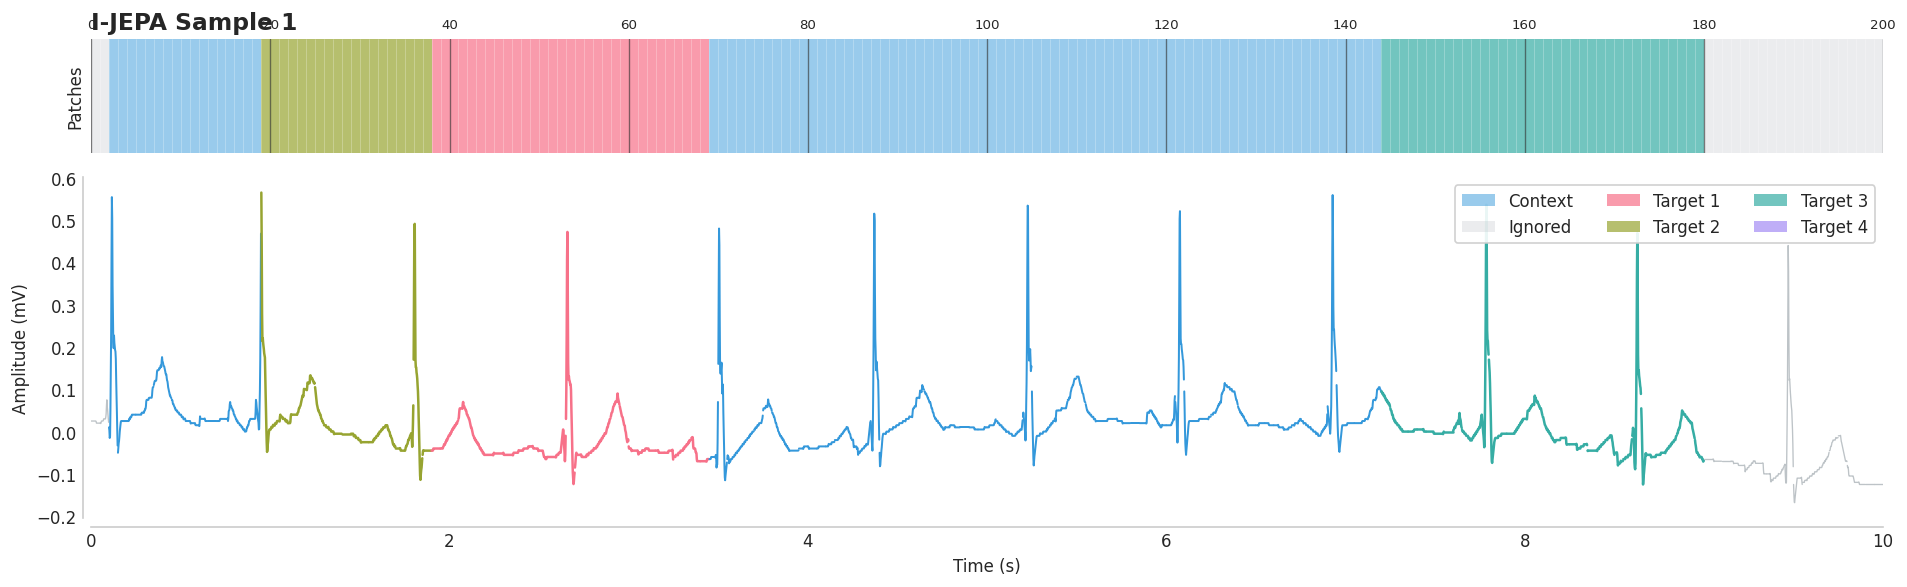

--- I-JEPA Sample 2 ---
Context: 70 patches (35.0%)
Targets: 109 patches (54.5%)
Ignored (neither): 21 patches (10.5%)
  T1: patches 122-152 (31 patches, 15.5%)
  T2: patches 106-144 (39 patches, 19.5%)
  T3: patches 144-179 (36 patches, 18.0%)
  T4: patches 37-71 (35 patches, 17.5%)
--------------------------------------------------


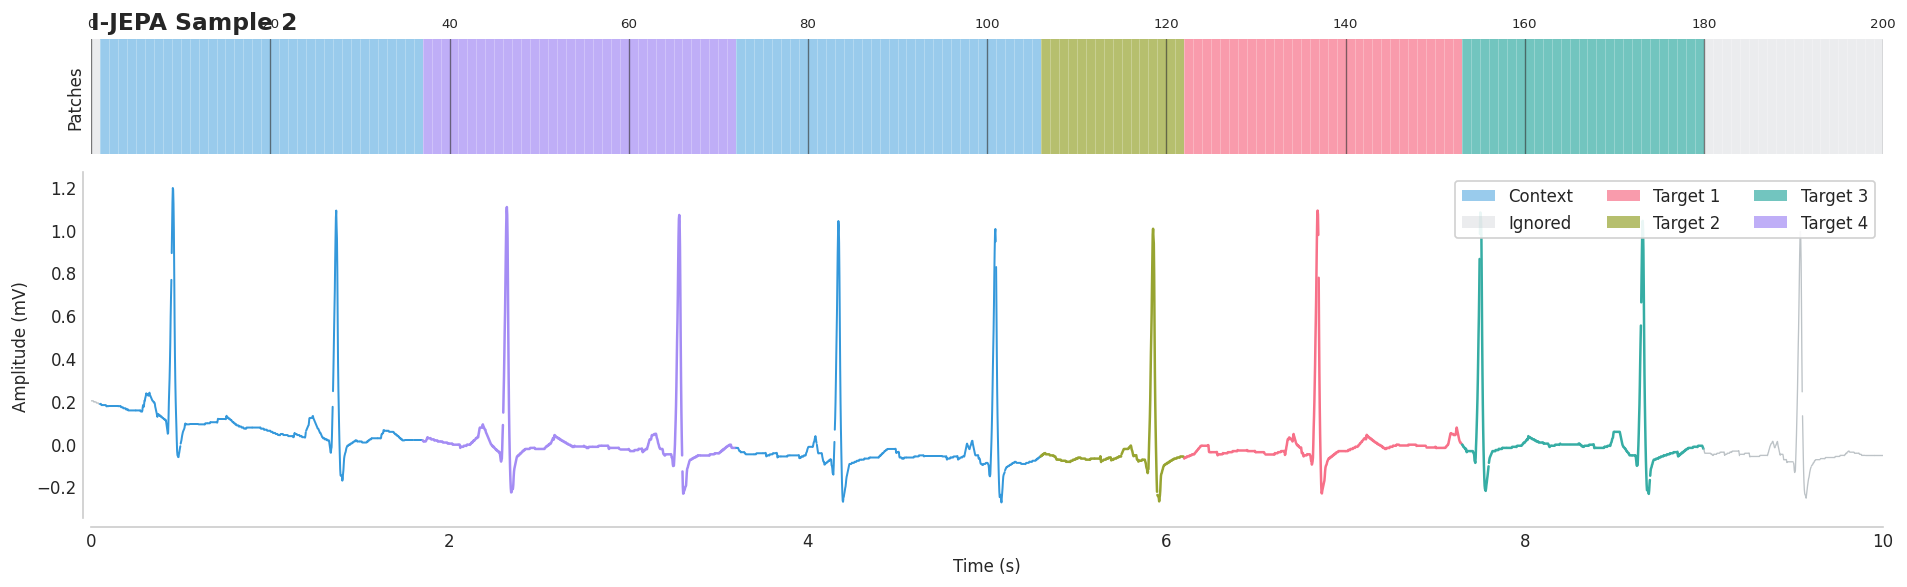

--- I-JEPA Sample 3 ---
Context: 55 patches (27.5%)
Targets: 123 patches (61.5%)
Ignored (neither): 22 patches (11.0%)
  T1: patches 88-118 (31 patches, 15.5%)
  T2: patches 18-56 (39 patches, 19.5%)
  T3: patches 105-140 (36 patches, 18.0%)
  T4: patches 54-88 (35 patches, 17.5%)
--------------------------------------------------


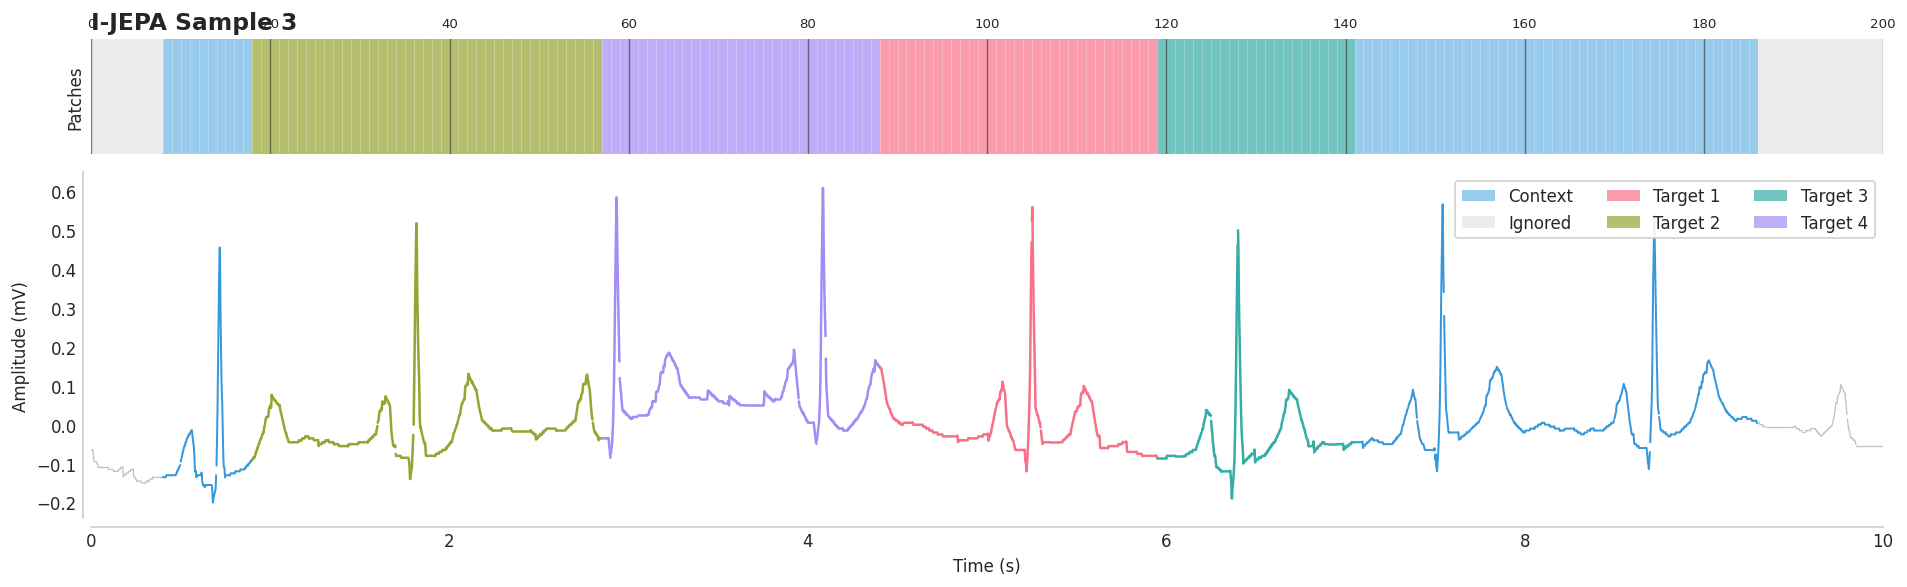

In [13]:
for i in range(NUM_EXAMPLES):
    ctx = ijepa_context_list[0][i].numpy().tolist()
    ctx = list(set(ctx))  # Remove padding duplicates
    
    target_blocks = []
    for t in ijepa_targets_list:
        block = list(set(t[i].numpy().tolist()))  # Remove padding duplicates
        target_blocks.append(block)
    
    plot_patch_level(ecgs[i], ctx, target_blocks, i, f"I-JEPA Sample {i+1}")

## Debug: Check Raw Mask Values

Let's verify what the collator is actually producing.

In [7]:
print("=== I-JEPA Raw Mask Analysis ===\n")

for i in range(NUM_EXAMPLES):
    ctx = np.unique(ijepa_context_list[0][i].numpy())
    
    print(f"Sample {i+1}:")
    print(f"  Context patches: {len(ctx)} unique values")
    print(f"  Context range: {ctx.min()} to {ctx.max()}")
    print(f"  Context span: {ctx.max() - ctx.min() + 1} patches ({(ctx.max() - ctx.min() + 1)/NUM_PATCHES*100:.1f}%)")
    
    all_targets = set()
    for j, t in enumerate(ijepa_targets_list):
        block = np.unique(t[i].numpy())
        all_targets.update(block.tolist())
        print(f"  Target {j+1}: patches {block.min()}-{block.max()} ({len(block)} patches)")
    
    # Check overlap
    ctx_set = set(ctx.tolist())
    overlap = ctx_set & all_targets
    print(f"  Overlap (removed from context): {len(overlap)} patches")
    print(f"  Final context after removal: {len(ctx_set - all_targets)} patches")
    print()

=== I-JEPA Raw Mask Analysis ===

Sample 1:
  Context patches: 44 unique values
  Context range: 2 to 45
  Context span: 44 patches (22.0%)
  Target 1: patches 80-110 (31 patches)
  Target 2: patches 116-152 (37 patches)
  Target 3: patches 166-197 (32 patches)
  Target 4: patches 123-159 (37 patches)
  Overlap (removed from context): 0 patches
  Final context after removal: 44 patches

Sample 2:
  Context patches: 44 unique values
  Context range: 13 to 91
  Context span: 79 patches (39.5%)
  Target 1: patches 20-54 (35 patches)
  Target 2: patches 156-192 (37 patches)
  Target 3: patches 115-152 (38 patches)
  Target 4: patches 158-192 (35 patches)
  Overlap (removed from context): 0 patches
  Final context after removal: 44 patches

Sample 3:
  Context patches: 44 unique values
  Context range: 10 to 121
  Context span: 112 patches (56.0%)
  Target 1: patches 18-47 (30 patches)
  Target 2: patches 80-117 (38 patches)
  Target 3: patches 153-191 (39 patches)
  Target 4: patches 122-1